In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms

from ipynb.fs.defs.ImportDB import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/home/jupyter/charliemacuject/research_papers/data/adherence_twoyears.csv', low_memory=False)

In [3]:
len(df)

198

In [67]:
df = df[df['time_above_baseline_1year'] != 'nil']
df['time_above_baseline_1year'] = pd.to_numeric(df['time_above_baseline_1year'])
df.dropna(subset=['time_above_baseline_1year'], inplace=True)
df = df[df['time_above_baseline_1year'] >= 0]
df = df[df['time_above_baseline_1year'] < 365]

In [59]:
df = df[df['time_above_baseline_2year'] != 'nil']
df['time_above_baseline_2year'] = pd.to_numeric(df['time_above_baseline_2year'])
df.dropna(subset=['time_above_baseline_2year'], inplace=True)
df = df[df['time_above_baseline_2year'] >= 0]
df = df[df['time_above_baseline_2year'] < 365]

In [62]:
df = df[df['time_above_baseline_4year'] != 'nil']
df['time_above_baseline_4year'] = pd.to_numeric(df['time_above_baseline_4year'])
df.dropna(subset=['time_above_baseline_4year'], inplace=True)
df = df[df['time_above_baseline_4year'] >= 0]
df = df[df['time_above_baseline_4year'] < 365]

In [4]:
class Stat_Test:
    
    def __init__(self, ad_measure, vis_outcome):
        self.ad_measure = ad_measure
        self.vis_outcome = vis_outcome
    
    def measures_print(self):
        print("The adherence measure is {}, and the visual outcome is {}.".format(self.ad_measure, self.vis_outcome))
        
    def median(self):
        median = np.median(df[self.ad_measure])
        return median
        
    def samples(self):
        median = np.median(df[self.ad_measure])
        early = df[df[self.ad_measure] < median]
        late = df[df[self.ad_measure] >= median]
        sample_1 = early[self.vis_outcome]
        sample_2 = late[self.vis_outcome]
        return sample_1, sample_2, median
    
    def t_test_ind(self):
        sample_1, sample_2, median = self.samples()
        t, pval = stats.ttest_ind(sample_1, sample_2)
        return t, pval
        
    def mann_whitney(self):
        sample_1, sample_2, median = self.samples()
        t, pval = stats.mannwhitneyu(sample_1, sample_2)
        return t, pval
            
    def all_tests(self):
        t_1, p_1 = self.t_test_ind()
        t_2, p_2 = self.mann_whitney()
        sample_1, sample_2, cutoff = self.samples()
        median = np.round(cutoff, 2)
        x_1, x_2 = np.mean(sample_1), np.mean(sample_2)
        print("Those in Group 1 had adherence measure less than {}, and those in Group 2 had adherence measure greater than {}.".format(median, median))
        print("The mean for Early is {} and the mean for Late is {}.".format(np.round(x_1, 2), np.round(x_2, 2)))
        print("The test statistic for the independent t-test is {} and the p-value is {}.".format(np.round(t_1, 3), 
                                                                                                     np.round(p_1, 5)))
        print("The test statistic for the parametric t-test is {} and the p-value is {}.".format(np.round(t_2, 3), 
                                                                                                     np.round(p_2, 5)))
        if p_1 < 0.05 and p_2 > 0.05:
            print("The independent t-test returned a significant result whilst the parametric t-test did not.")
        elif p_1 > 0.05 and p_2 < 0.05:
            print("The parametric t-test returned a significant result whilst the independent t-test did not.")
        elif p_1 < 0.05 and p_2 < 0.05:
            print("Both tests returned a significant result.")
        else:
            print("Neither test returned a significant result. It is likely these are the same distribution.")
            
    # rotating samples function
    def samples_search(self):
        minimum = np.round(df[self.ad_measure].min(), 2)
        maximum = np.round(df[self.ad_measure].max(), 2)
        data_range = np.linspace(minimum, maximum, 100)
        diff, cut_point, len_s1, len_s2, mean_1, mean_2, p_value = 0, 0, 0, 0, 0, 0, 100
        for i in range(len(data_range)):
            cutoff = data_range[i]
            early = df[df[self.ad_measure] < cutoff]
            late = df[df[self.ad_measure] >= cutoff]
            if len(early) != 0 and len(late) != 0:
                sample_1, sample_2 = early[self.vis_outcome], late[self.vis_outcome]
                x_1, x_2 = np.mean(sample_1), np.mean(sample_2)
                t, pval = self.mann_whitney()
                if pval < 0.05 and abs(x_1 - x_2) > diff and len(sample_1) > 50 and len(sample_2) > 50:
                    difference = abs(x_1 - x_2)
                    diff = np.round(difference, 4)
                    mean_1, mean_2 = np.round(x_1, 2), np.round(x_2, 2)
                    cut_point = np.round(cutoff, 4)
                    len_s1, len_s2 = len(sample_1), len(sample_2)
                    p_value = np.round(pval, 5)
                    i += 1
                else: 
                    i += 1
        return diff, cut_point, len_s1, len_s2, mean_1, mean_2, p_value

    def confidence_interval(self, sample_1, sample_2):
        cm = sms.CompareMeans(sms.DescrStatsW(sample_1), sms.DescrStatsW(sample_2))
        conf_int = cm.tconfint_diff(usevar='unequal')
        return conf_int
    
    def samples_ci(self, cut):
        early = df[df[self.ad_measure] < cut]
        late = df[df[self.ad_measure] >= cut]
        sample_1 = early[self.vis_outcome]
        sample_2 = late[self.vis_outcome]
        return sample_1, sample_2

    
    # print results from sample_search
    def print_samples_search(self):
        diff, cut_point, len_s1, len_s2, mean_1, mean_2, p_value = self.samples_search()
        sample_1, sample_2 = self.samples_ci(cut_point)
        ci = self.confidence_interval(sample_1,sample_2)
        if diff > 0:
            print("Adherence measure: {}".format(self.ad_measure))
            print("The cutoff point which maximised the difference in visual outcome between the groups is {}.".format(cut_point))
            print("This gave a p-value of {}, with {} people in the EARLY GROUP and {} people in the LATE GROUP.".format(p_value, len_s1, len_s2))
            print("The early group had mean {} of {}, and the late group had mean {} of {}.".format(self.vis_outcome, mean_1, self.vis_outcome, mean_2))
            print("Thus, the maximum difference in {} between the two groups (that maintained significance) was {}.".format(self.vis_outcome, diff))
            print("This gave a confidence interval of {}.".format(ci))
        else:
            print("There was no cutoff point for {} that found a significant difference in {}.".format(self.ad_measure, self.vis_outcome))

In [10]:
class Results:
    
    def __init__(self, initiation=False):
        self.initiation = initiation
    
    def get_df(self):
        """
        Returns the appropriate dataframe (initiation or whole).
        """
        if self.initiation == False:
            df = pd.read_csv('/home/jupyter/charliemacuject/research_papers/data/adherence_dataframe.csv', 
                             low_memory=False)
        else:
            df = pd.read_csv('/home/jupyter/charliemacuject/research_papers/data/adherence_initiation.csv', 
                             low_memory=False)
    
    def all_cutoff_points_print(self):
        ad_measures = ['mean_adherence', 'adherence_variation',
           'percentage_late', 'percentage_early', 'MAFL', 'MAFE']
        vis_outcomes = ['mean_vision', 'proportion_above_baseline',
           'peak_visual_improvement', 'loss_from_peak', 'time_to_peak']
        for i in range(len(ad_measures)):
            for j in range(len(vis_outcomes)):
                p1 = Stat_Test(ad_measures[i], vis_outcomes[j])
                p1.print_samples_search()
                print("       ")
                
    def all_combinations():
        results = pd.DataFrame(columns = ['mean_adherence', 'adherence_variation',
           'percentage_late', 'MAFL', 'MAFE'], index = ['mean_vision',
           'time_above_baseline_1year', 'time_above_baseline_2year',
           'time_above_baseline_4year', 'proportion_above_baseline',
           'peak_visual_improvement', 'loss_from_peak', 'time_to_peak'])
        ad_measures = ['mean_adherence', 'adherence_variation',
           'percentage_late', 'MAFL', 'MAFE']
        vis_outcomes = ['mean_vision',
           'time_above_baseline_1year', 'time_above_baseline_2year',
           'time_above_baseline_4year', 'proportion_above_baseline',
           'peak_visual_improvement', 'loss_from_peak', 'time_to_peak']
        for i in range(len(ad_measures)):
            for j in range(len(vis_outcomes)):
                p1 = Stat_Test(ad_measures[i], vis_outcomes[j])
                t, pval = p1.t_test_ind()
                results[ad_measures[i]][vis_outcomes[j]] = pval
        return results

In [20]:
def all_combinations():
    results = pd.DataFrame(columns = ['mean_adherence', 'adherence_variation',
       'percentage_late', 'MAFL', 'MAFE'], index = ['mean_vision',
       'time_above_baseline_1year', 'time_above_baseline_2year',
       'time_above_baseline_4year', 'proportion_above_baseline',
       'peak_visual_improvement', 'loss_from_peak', 'time_to_peak'])
    ad_measures = ['mean_adherence', 'adherence_variation',
       'percentage_late', 'MAFL', 'MAFE']
    vis_outcomes = ['mean_vision',
       'time_above_baseline_1year', 'time_above_baseline_2year',
       'time_above_baseline_4year', 'proportion_above_baseline',
       'peak_visual_improvement', 'loss_from_peak', 'time_to_peak']
    for i in range(len(ad_measures)):
        for j in range(len(vis_outcomes)):
            p1 = Stat_Test(ad_measures[i], vis_outcomes[j])
            t, pval = p1.t_test_ind()
            results[ad_measures[i]][vis_outcomes[j]] = pval
    return results

In [15]:
p1 = Stat_Test("percentage_late", "loss_from_peak")
p1.all_tests()

Those in Group 1 had adherence measure less than 0.2, and those in Group 2 had adherence measure greater than 0.2.
The mean for Early is 0.18 and the mean for Late is 0.2.
The test statistic for the independent t-test is -1.442 and the p-value is 0.15019.
The test statistic for the parametric t-test is 12289.0 and the p-value is 0.07541.
Neither test returned a significant result. It is likely these are the same distribution.


In [5]:
def all_cutoff_points_print():
    ad_measures = ['mean_adherence', 'adherence_variation',
       'percentage_late', 'percentage_early', 'MAFL', 'MAFE', 'adherence_year1', 'adherence_year2']
    vis_outcomes = ['mean_vision', 'peak_visual_improvement', 'time_above_baseline', 'overall_visual_change']
    for i in range(len(ad_measures)):
        for j in range(len(vis_outcomes)):
            p1 = Stat_Test(ad_measures[i], vis_outcomes[j])
            p1.print_samples_search()
            print("       ")
            
all_cutoff_points_print()

Adherence measure: mean_adherence
The cutoff point which maximised the difference in visual outcome between the groups is 1.0032.
This gave a p-value of 0.01952, with 92 people in the EARLY GROUP and 106 people in the LATE GROUP.
The early group had mean mean_vision of 58.43, and the late group had mean mean_vision of 48.09.
Thus, the maximum difference in mean_vision between the two groups (that maintained significance) was 10.3318.
This gave a confidence interval of (2.196450192753213, 18.46724480314507).
       
There was no cutoff point for mean_adherence that found a significant difference in peak_visual_improvement.
       
There was no cutoff point for mean_adherence that found a significant difference in time_above_baseline.
       
There was no cutoff point for mean_adherence that found a significant difference in overall_visual_change.
       
Adherence measure: adherence_variation
The cutoff point which maximised the difference in visual outcome between the groups is 0.1315.

# Starting vision

In [46]:
df = pd.read_csv('/home/jupyter/charliemacuject/research_papers/data/adherence_dataframe.csv')

In [40]:
df_low = df[df['baseline'] < 0.3]
df_high = df[df['baseline'] >= 0.3]

In [43]:
visual_outcomes = ['peak_visual_improvement', 'loss_from_peak', 'proportion_above_baseline']
for outcome in visual_outcomes:
    print("For the low baseliners, the mean {} was {}.".format(outcome, np.mean(df_low[outcome])))
    print("For the high baseliners, the mean {} was {}.".format(outcome, np.mean(df_high[outcome])))
    print(" ")

For the low baseliners, the mean peak_visual_improvement was 15.06190142857143.
For the high baseliners, the mean peak_visual_improvement was 19.15151606060607.
 
For the low baseliners, the mean loss_from_peak was 9.307142142857144.
For the high baseliners, the mean loss_from_peak was 20.44444181818182.
 
For the low baseliners, the mean proportion_above_baseline was 0.18528214285714287.
For the high baseliners, the mean proportion_above_baseline was 0.5197590909090912.
 


In [50]:
len(df_low), len(df_high)

(140, 330)

# Improvement

In [47]:
df_stag = df[df['peak_visual_improvement'] == 0]
df_imp = df[df['peak_visual_improvement'] > 0]

In [48]:
len(df_stag)

109

In [49]:
len(df_imp)

361

In [51]:
visual_outcomes = ['peak_visual_improvement', 'loss_from_peak', 'proportion_above_baseline']
for outcome in visual_outcomes:
    print("For the stags, the mean {} was {}.".format(outcome, np.mean(df_stag[outcome])))
    print("For the imps, the mean {} was {}.".format(outcome, np.mean(df_imp[outcome])))
    print(" ")

For the stags, the mean peak_visual_improvement was 0.0.
For the imps, the mean peak_visual_improvement was 23.348106648199444.
 
For the stags, the mean loss_from_peak was 12.443423853211009.
For the imps, the mean loss_from_peak was 18.54108725761773.
 
For the stags, the mean proportion_above_baseline was 0.00688073394495413.
For the imps, the mean proportion_above_baseline was 0.544903047091413.
 


# Random forest

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from fastai.tabular.all import *
from IPython.display import Image, display_svg, SVG
from sklearn import metrics, datasets, ensemble
from fastbook import *

In [46]:
df = pd.read_csv('/home/jupyter/charliemacuject/research_papers/data/adherence_twoyears.csv', low_memory=False)

In [47]:
dep_var = 'mean_vision'

In [48]:
y = np.log(df[dep_var])

In [49]:
X = df.drop(columns=['mean_vision'])

In [50]:
xs, valid_xs, y, valid_y = train_test_split(X, y, test_size=0.15, random_state=42)

In [51]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y);

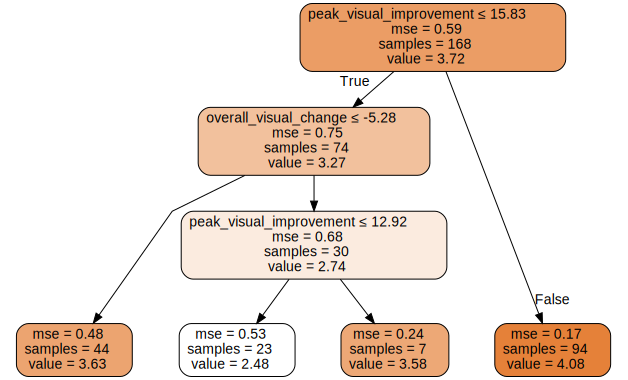

In [52]:
draw_tree(m, xs, size=10, leaves_parallel=True, precision=2)

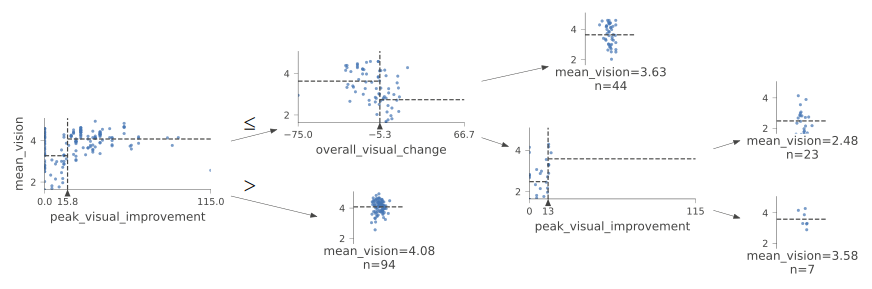

In [53]:
samp_idx = np.random.permutation(len(y))[:500]
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

In [54]:
m = DecisionTreeRegressor()
m.fit(xs, y);

In [55]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [56]:
m_rmse(m, xs, y)

0.0

In [57]:
m_rmse(m, valid_xs, valid_y)

0.691112

In [58]:
m.get_n_leaves(), len(xs)

(167, 168)

In [64]:
m = DecisionTreeRegressor(min_samples_leaf=75)
m.fit(xs, y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.65642, 0.618592)